In [45]:
%load_ext autoreload
%autoreload 2
import os
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape == y_pred.shape and len(y_pred.shape) == 1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [47]:
def get_drift_files(config):
    ts_type = "QuadSinHF" if "QuadSinHF" in config.data_path else "BiPot"
    ts_type = f"{ts_type}"
    try:
        include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
            ".", "")
    except AttributeError as e:
        include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    print(ts_type, include)
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "Hermite" in file and ts_type in file and include in file and "DriftTrack" in file:
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")
        print(match)
        match = match[3][0]
        return int(match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    Rs = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, Rs

In [48]:
config = get_config()
global_files, true_files, local_files, Rs = get_drift_files(config=config)
global_files

BiPot 3906e-03dT_025a_-05b_00c
['Hermite', 'fBiPot', 'DriftTrack', '2R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'global', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '8R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'global', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '2R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'true', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '8R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'true', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '2R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'local', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '8R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'local', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '2R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b', '00c', 'global', 'states.npy']
['Hermite', 'fBiPot', 'DriftTrack', '8R', '10952NPaths', '00t0', '3906e-03dT', '025a', '-05b'

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_2R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/Hermite_fBiPot_DriftTrack_8R_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy']

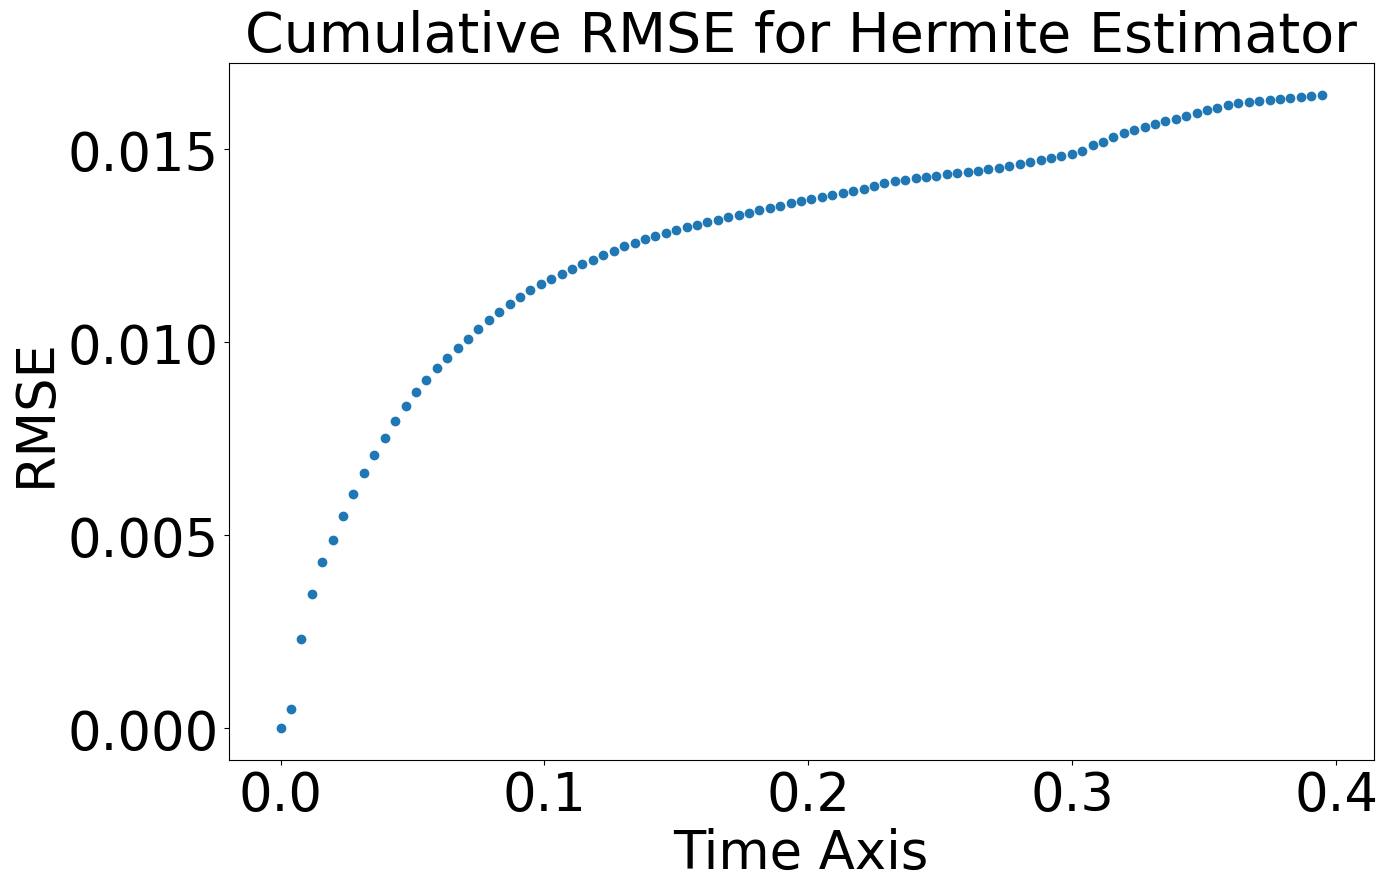

Final time cumulative RMSE local-time error 0.016413764688912643 at R 2



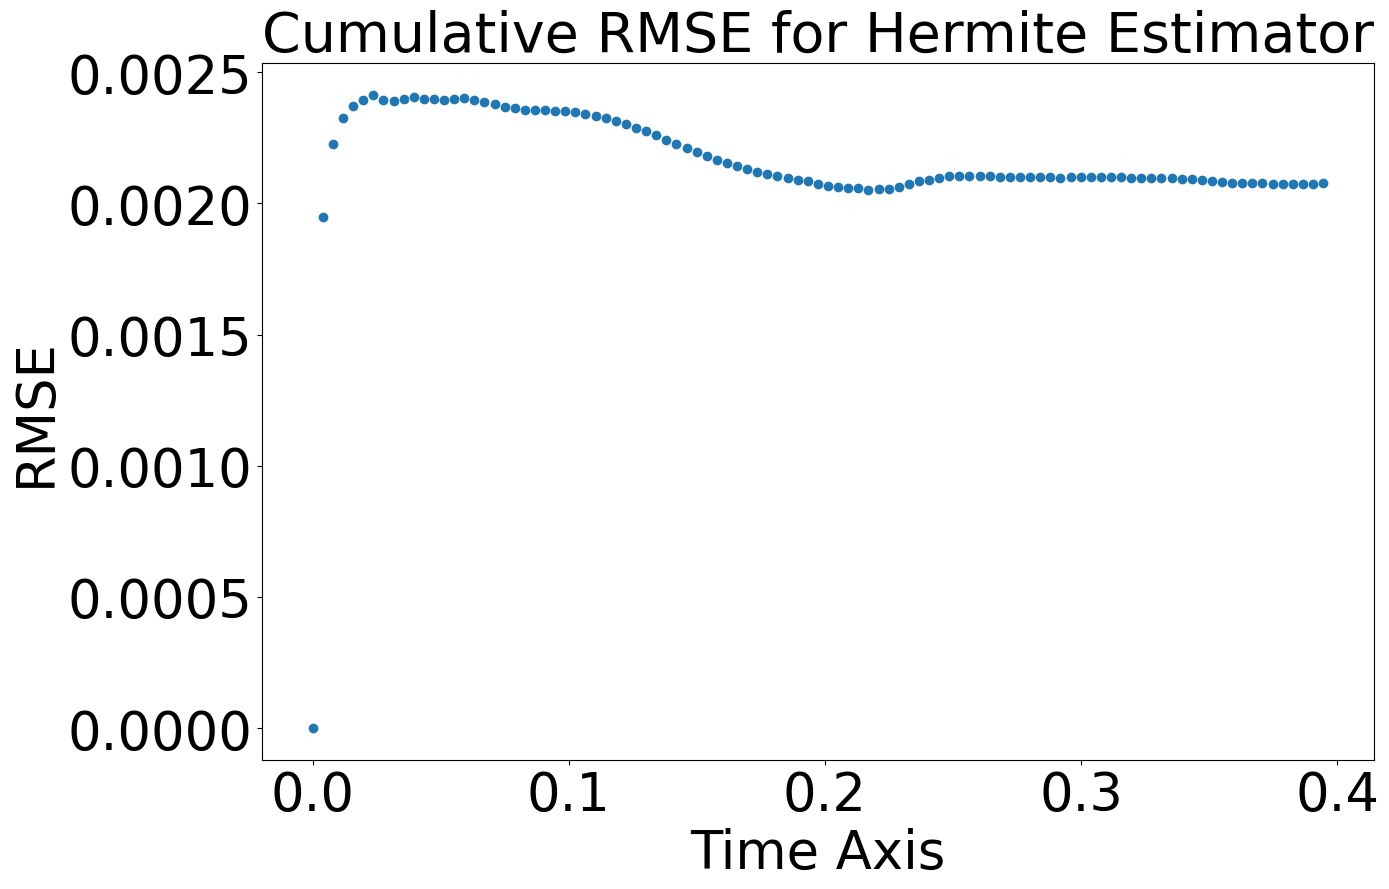

Final time cumulative RMSE local-time error 0.002077839137670536 at R 8



In [49]:
local_bw_rmses = np.inf
for file in zip(*[true_files, global_files, local_files, Rs]):
    R = file[-1]
    true_states = np.load(file[0])/np.sqrt(config.deltaT)
    global_states= np.load(file[1])/np.sqrt(config.deltaT)
    local_states = np.load(file[2])/np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    if total_local_errors[-1] < local_bw_rmses:
        local_bw_rmses = total_local_errors[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
        ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
        ax.set_title(f"Cumulative RMSE for Hermite Estimator", fontsize=40)
        ax.set_ylabel("RMSE", fontsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        plt.tight_layout()
        plt.show()
        plt.close()
        print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at R {R}\n")
